# Common part

- Dataset 1 (general): [link](https://mavenanalytics.io/data-playground)
- Dataset 2 (sentiment analysis): [link](https://huggingface.co/datasets/kcimc/NUFORC/tree/main)

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

tqdm.pandas()  # Registers the progress_apply method

COLOR = '#727272'
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['figure.dpi'] = 200

df = pd.read_csv(
    "../../../ufo_sightings_scrubbed.csv",
    low_memory=False
)

# Drop unnecessary columns
# df.drop(columns=['city', 'state', 'country', 'duration (hours/min)'], inplace=True)
df.drop(columns=['duration (hours/min)'], inplace=True)

# Rename columns
df.rename(columns={'duration (seconds)': 'duration'}, inplace=True)

# Fix missing states
df.loc[df['country'].isna() & df['state'].notna(), 'country'] = 'us'
df.dropna(subset=['country', 'state'], how='all', inplace=True)

# Fix dates
df['datetime'] = pd.to_datetime(df['datetime'])
df['date posted'] = pd.to_datetime(df['date posted'])

# Fix numbers
df['duration'] = pd.to_numeric(df['duration'], errors='coerce')
df['duration'].dropna(inplace=True)

# Swap datetime and date posted if datetime is greater than date posted
mask = df['datetime'].dt.date > df['date posted'].dt.date
df.loc[mask, ['datetime', 'date posted']] = df.loc[mask, ['date posted', 'datetime']].values


# Shape mapping
shape_mappings = {
    'cylinder': 'cylinder',
    'light': 'flash',
    'circle': 'disk',
    'sphere': 'sphere',
    'disk': 'disk',
    'fireball': 'fireball',
    'unknown': 'unknown',
    'oval': 'oval',
    'other': 'other',
    'cigar': 'cylinder',
    'rectangle': 'rectangle',
    'chevron': 'chevron',
    'triangle': 'triangle',
    'formation': 'formation',
    'delta': 'triangle',
    'changing': 'changing',
    'egg': 'oval',
    'diamond': 'diamond',
    'flash': 'flash',
    'teardrop': 'teardrop',
    'cone': 'cone',
    'cross': 'cross',
    'pyramid': 'other',
    'round': 'disk',
    'crescent': 'changing',
    'flare': 'flash',
    'hexagon': 'other',
    'dome': 'other',
    'changed': 'changing',
    np.nan: 'unknown'
}
df['shape'] = df['shape'].str.lower().map(shape_mappings)

# Remove incomplete year (2014)
df = df[df['datetime'].dt.year != 2014]

# Part 2

- Dataset 2 (sentiment analysis): [link](https://huggingface.co/datasets/kcimc/NUFORC/tree/main)

## Alternative dataset

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import re

df = pd.read_csv(
    "../../../nuforc_bool.csv",
).rename(columns={
    'Sighting': 'Row ID',
    'Text': 'Comments',
    'Occurred': 'Datetime',
    'Duration': 'Duration (text)',
}).set_index('Row ID')

df.drop(columns=['Summary', 'Posted'], inplace=True)
df.rename(columns={ 'Reported': 'Date Posted' }, inplace=True)
df['Shape'] = df['Shape'].str.lower().map(shape_mappings)

# Convert headings to lowercase
df.columns = df.columns.str.lower()

# Fix dates
timezone_mapping = {
    "Pacific": "PST",    
    "Eastern": "EST",    
    "Central": "CST",    
    "Mountain": "MST",   
    "UTC": "UTC",
    "GMT": "GMT",
    "Local": "",  # Remove 'local' to keep datetime naive
}

def map_timezone(s):
    if pd.isna(s):
        return s
    # Extract last word
    last_word = re.findall(r'\b(\w+)$', s)
    if last_word and last_word[0] in timezone_mapping:
        # Replace last word with mapped timezone
        return re.sub(r'\b\w+$', timezone_mapping[last_word[0]], s)
    return s

# TODO there are outlier dates! e.g. 1639
df['datetime'] = pd.to_datetime(df['datetime'].apply(map_timezone), errors='coerce')
df['date posted'] = pd.to_datetime(df['date posted'].apply(map_timezone))

# Extract duration in seconds using regex
# TODO use better technique
def extract_duration(duration):
    if not isinstance(duration, str):
        return np.nan
    # Match hours (e.g., "2 hours", "1hr")
    match_hr = re.search(r'(\d+)\s*hour', duration, re.IGNORECASE)
    if match_hr:
        return int(match_hr.group(1)) * 3600
    # Match minutes (e.g., "2 min", "20minutes")
    match_min = re.search(r'(\d+)\s*min', duration, re.IGNORECASE)
    if match_min:
        return int(match_min.group(1)) * 60
    # Match seconds (e.g., "30 seconds")
    match_sec = re.search(r'(\d+)\s*sec', duration, re.IGNORECASE)
    if match_sec:
        return int(match_sec.group(1))
    return np.nan

df['duration'] = df['duration (text)'].apply(extract_duration)

# Drop unnecessary columns and NAs
df.dropna(subset=['location', 'date posted', 'datetime'], inplace=True)

df_sent = df.dropna(subset=['comments']).copy()

/var/folders/gq/c0m9vgqx2_vflttb1fnkyw1r0000gn/T/ipykernel_35000/2561801776.py:45: FutureWarning: Parsed string "2014-10-23 11:11:17 PST" included an un-recognized timezone "PST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['date posted'] = pd.to_datetime(df['date posted'].apply(map_timezone))


## NLT Pre-processing

In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Only first time
# nltk.download('all')

df_sent = df.dropna(subset=['comments']).copy()

# Load resources once
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Updated preprocess_text function to handle all HTML-like codes
def preprocess_text(text, max_words=None):
    if not isinstance(text, str):
        return ""
    # Remove HTML-like codes using regex (e.g., &amp;, &#39;, etc.)
    # text = re.sub(r'&[#a-zA-Z0-9]+;', ' ', text)
    # Tokenize and truncate
    tokens = word_tokenize(text.lower())
    # Truncate if max_words is specified
    if max_words is not None:
        tokens = tokens[:max_words]
    # Remove stopwords
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # Lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

# Apply the updated function
df_sent['lemmatized comments'] = df_sent['comments'].progress_apply(lambda x: preprocess_text(x))

  0%|          | 0/130963 [00:00<?, ?it/s]

## NLT Sentiment analysis

### (ignore) Method 1: Sentiment Analysis with BoW Model (Vader)
Problem: since text is short, 95% is neutral and 3% is compound

In [5]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# initialize NLTK sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    # Tresholding for sentiment
    sentiment = max(['pos', 'neu', 'neg'], key=lambda x: scores[x])
    return sentiment

# apply get_sentiment function
df_sent['sentiment'] = df_sent['lemmatized comments'].progress_apply(get_sentiment)

df_sent['sentiment'].value_counts()

  0%|          | 0/130963 [00:00<?, ?it/s]

sentiment
neu    130730
pos       184
neg        49
Name: count, dtype: int64

### (ignore) Method 2: Sentiment Analsys with Pre-trained Transformer Model (BERT)

In [5]:
from transformers import pipeline

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    top_k=1,
    truncation=True,
	max_length=512
)

df_sent_sample = df_sent.sample(n=5000, random_state=42)
df_sent_sample['sentiment'] = df_sent_sample['comments'].progress_apply(
    lambda x: sentiment_pipeline(x)[0][0]['label']
)

# Visualizza i risultati
df_sent_sample[['comments', 'sentiment']]

Device set to use mps:0


  0%|          | 0/5000 [00:00<?, ?it/s]

comments sentiment
Row ID                                                             
62046   My roommate and I were in the back yard when I...  NEGATIVE
44293   Myself and wife were driving home from an even...  NEGATIVE
20554   and one more information, they were going in t...  NEGATIVE
164960  Tonight walking along the water outside my Con...  NEGATIVE
80273   Woke up at 4 am to get a drink and saw my sist...  NEGATIVE
...                                                   ...       ...
114011  Witness elects to remain totally anonymous; pr...  NEGATIVE
162396  Saw massive ball of light moving in circular m...  NEGATIVE
22823   These vessels are indeed an ultimate in   phys...  NEGATIVE
162478  It looked like a combination of a very slow mo...  NEGATIVE
156060  Large golden sparkle at night. It has been app...  NEGATIVE

[5000 rows x 2 columns]

### Method 3: Emotional Analysis with cherry-picking words

In [60]:
# Define a list of emotion-related keywords
emotion_keywords = [
    'fear', 'hopeful', 'shocked', 'confused', 'joy',
    'scared', 'curious', 'sad', 'surprised', 'excited'
]

# Create a column for each emotion keyword (lemmatized)
for emotion in [lemmatizer.lemmatize(word) for word in emotion_keywords]:
    df_sent[emotion] = df_sent['lemmatized comments'].progress_apply(lambda x: emotion in x.lower() if isinstance(x, str) else False)

# Display the updated dataframe with the new emotion columns
df_sent[['comments'] + emotion_keywords]

df_sent.to_csv("../../../_nuforc_sent.csv")

# Count the number of rows for each emotion
df_sent[emotion_keywords].sum().sort_values()

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

sad           433
hopeful       494
confused      893
surprised    1234
shocked      1351
excited      1596
joy          1662
fear         1672
curious      1753
scared       3421
dtype: int64

### (ignore) Method 4: Emotional Analsysis with model (RoBERTa)

In [58]:
from transformers import pipeline

# Use a faster emotion model and limit to 5,000 records
emotion_pipeline = pipeline(
    "text-classification",
    # model="cardiffnlp/twitter-roberta-base-emotion",
    model="j-hartmann/emotion-english-distilroberta-base", 
    top_k=1,
    truncation=True,
	max_length=512
)

# Limit records for speed
df_sent_sample = df_sent.sample(n=5000, random_state=42).copy()

# Apply the pipeline (truncate input for speed)
df_sent_sample['emotion'] = df_sent_sample['comments'].progress_apply(
    lambda x: emotion_pipeline(x)[0][0]['label']
)

df_sent_sample[['comments', 'emotion']]

Device set to use mps:0


  0%|          | 0/5000 [00:00<?, ?it/s]

AttributeError: 'str' object has no attribute 'sort_values'

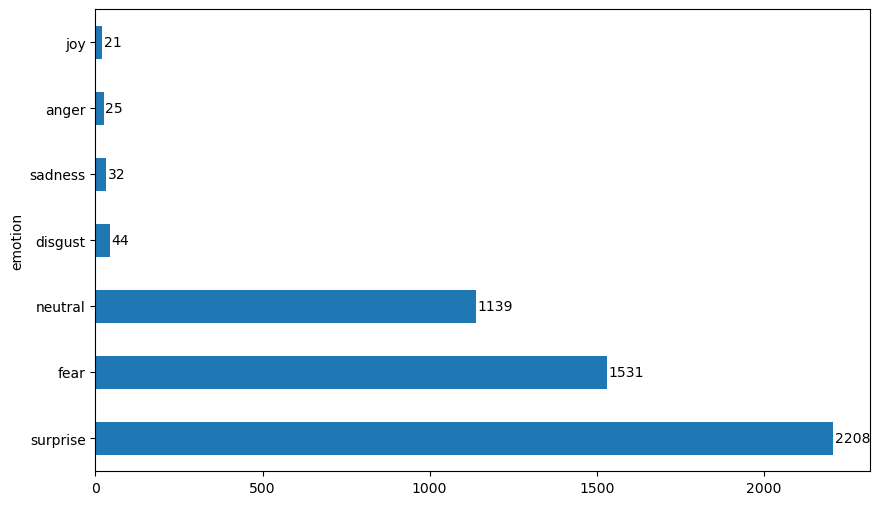

In [62]:
ax = df_sent_sample['emotion'].value_counts().sort_values(ascending=False).plot(kind='barh', figsize=(10, 6))

# Annotate each bar with its value
for i, v in enumerate(df_sent_sample['emotion'].value_counts().sort_values(ascending=False)):
    ax.text(v + 5, i, str(v), color='black', va='center')

plt.show()

## Visualizations (Methods 3)
Chose this method because the others were too resource-intense and there are a lot of outliers in the text.

### Most frequent emotions

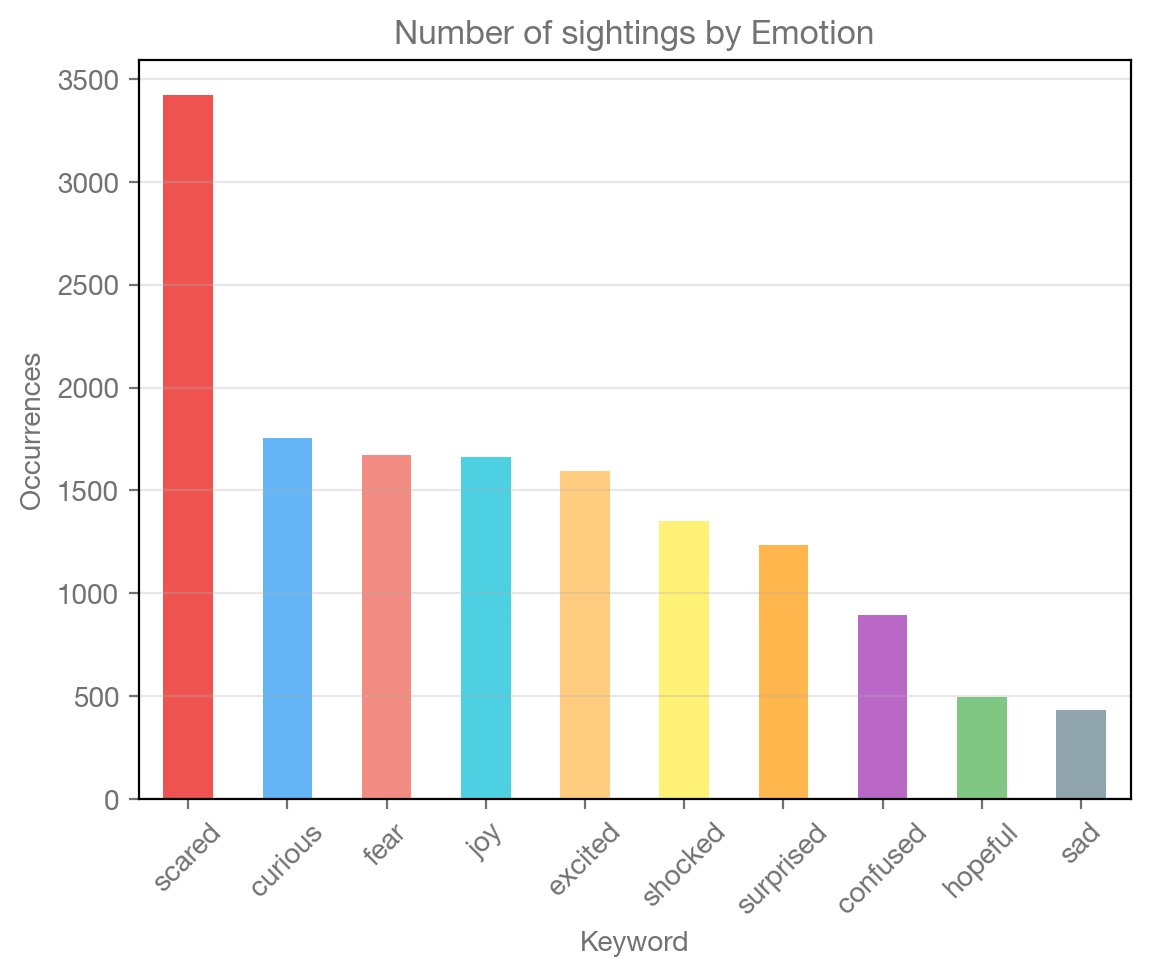

In [100]:
# ------
# Setup 
# ------

df_sent = pd.read_csv("../../../_nuforc_sent.csv")
df_sent['datetime'] = pd.to_datetime(df_sent['datetime'].apply(map_timezone), errors='coerce')
df_sent['date posted'] = pd.to_datetime(df_sent['date posted'].apply(map_timezone))

# Define a color for each emotion keyword
emotion_colors = {
    emotion_keywords[0]: '#f28b82',  # brighter pastel red
    emotion_keywords[1]: '#81c784',  # brighter pastel green
    emotion_keywords[2]: '#fff176',  # brighter pastel yellow
    emotion_keywords[3]: '#ba68c8',  # brighter pastel purple
    emotion_keywords[4]: '#4dd0e1',  # brighter pastel teal
    emotion_keywords[5]: '#ef5350',  # brighter pastel dark red
    emotion_keywords[6]: '#64b5f6',  # brighter pastel blue
    emotion_keywords[7]: '#90a4ae',  # brighter pastel dark blue
    emotion_keywords[8]: '#ffb74d',  # brighter pastel orange
    emotion_keywords[9]: '#ffcc80',  # brighter pastel gold
}

# ------
# End setup
# ------

emotion_counts = df_sent[emotion_keywords].sum().sort_values(ascending=False)
emotion_counts.plot(
    kind="bar", 
    color=[emotion_colors.get(emotion) for emotion in emotion_counts.index]
)
plt.title("Number of sightings by Emotion")
plt.xlabel("Keyword")
plt.ylabel("Occurrences")
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.show()

The plot clearly shows that Scared is the most occurring emotion in the dataset, with almost 3500 matches. The least represented are Hopeful and Sad, having less than 500 references. Curious, Fear, Joy, and Excited are almost at the same level, with around 1600 occurrences each.

### Emotion vs Time of the Day
Apparently no relevant differences

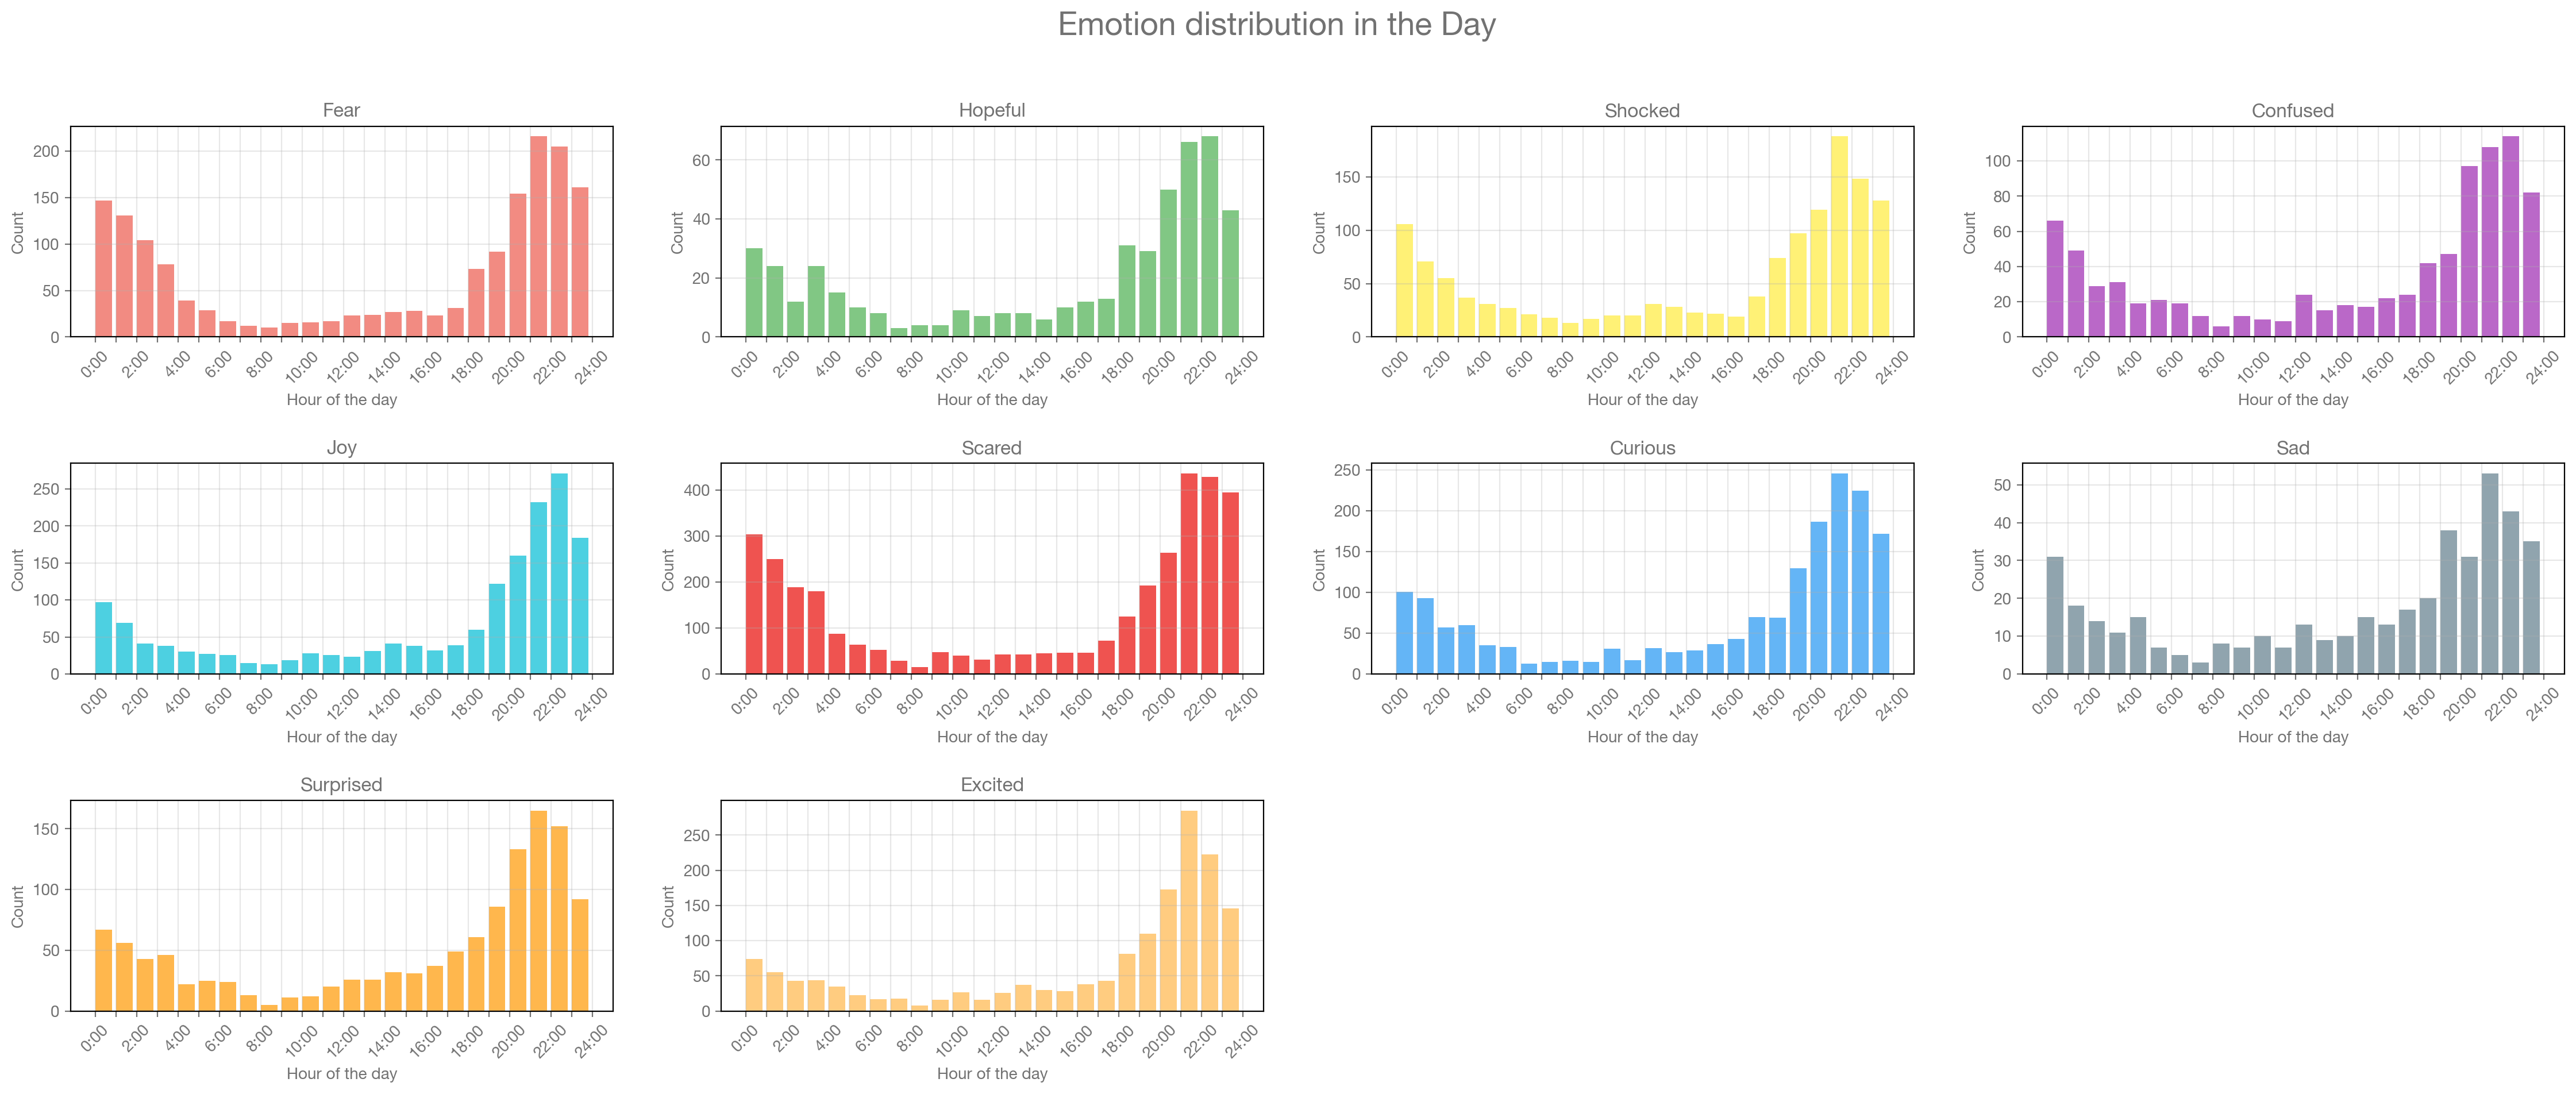

In [101]:
fig, axes = plt.subplots(3, 4, figsize=(28, 10))

for e, ax in zip(emotion_keywords, axes.flatten()):
    # Filter the DataFrame for the current emotion
    df_emotion = df_sent[df_sent[e] == True]
    
    # Count occurrences by hour
    df_emotion_count = df_emotion['datetime'].dt.hour.value_counts().sort_index().reset_index()
    df_emotion_count.columns = ['hour', 'count']
    
    ax.bar(
        df_emotion_count['hour'], 
        df_emotion_count['count'], 
        color=emotion_colors.get(e), 
        align="edge"
    )
    ax.set_xticks(range(0, 25))
    ax.set_xticklabels([f"{h}:00" if h % 2 == 0 else "" for h in range(0, 25)], rotation=45)
    ax.set_title(e.capitalize())
    ax.set_xlabel('Hour of the day')
    ax.set_ylabel('Count')
    ax.grid(alpha=0.3)

# Hide unused subplots
for ax in axes.flatten()[len(emotion_keywords):]:
    ax.axis('off')

fig.suptitle('Emotion distribution in the Day', fontsize=20)
plt.subplots_adjust(hspace=0.6, wspace=0.2)
plt.show()

### Emotion vs Years

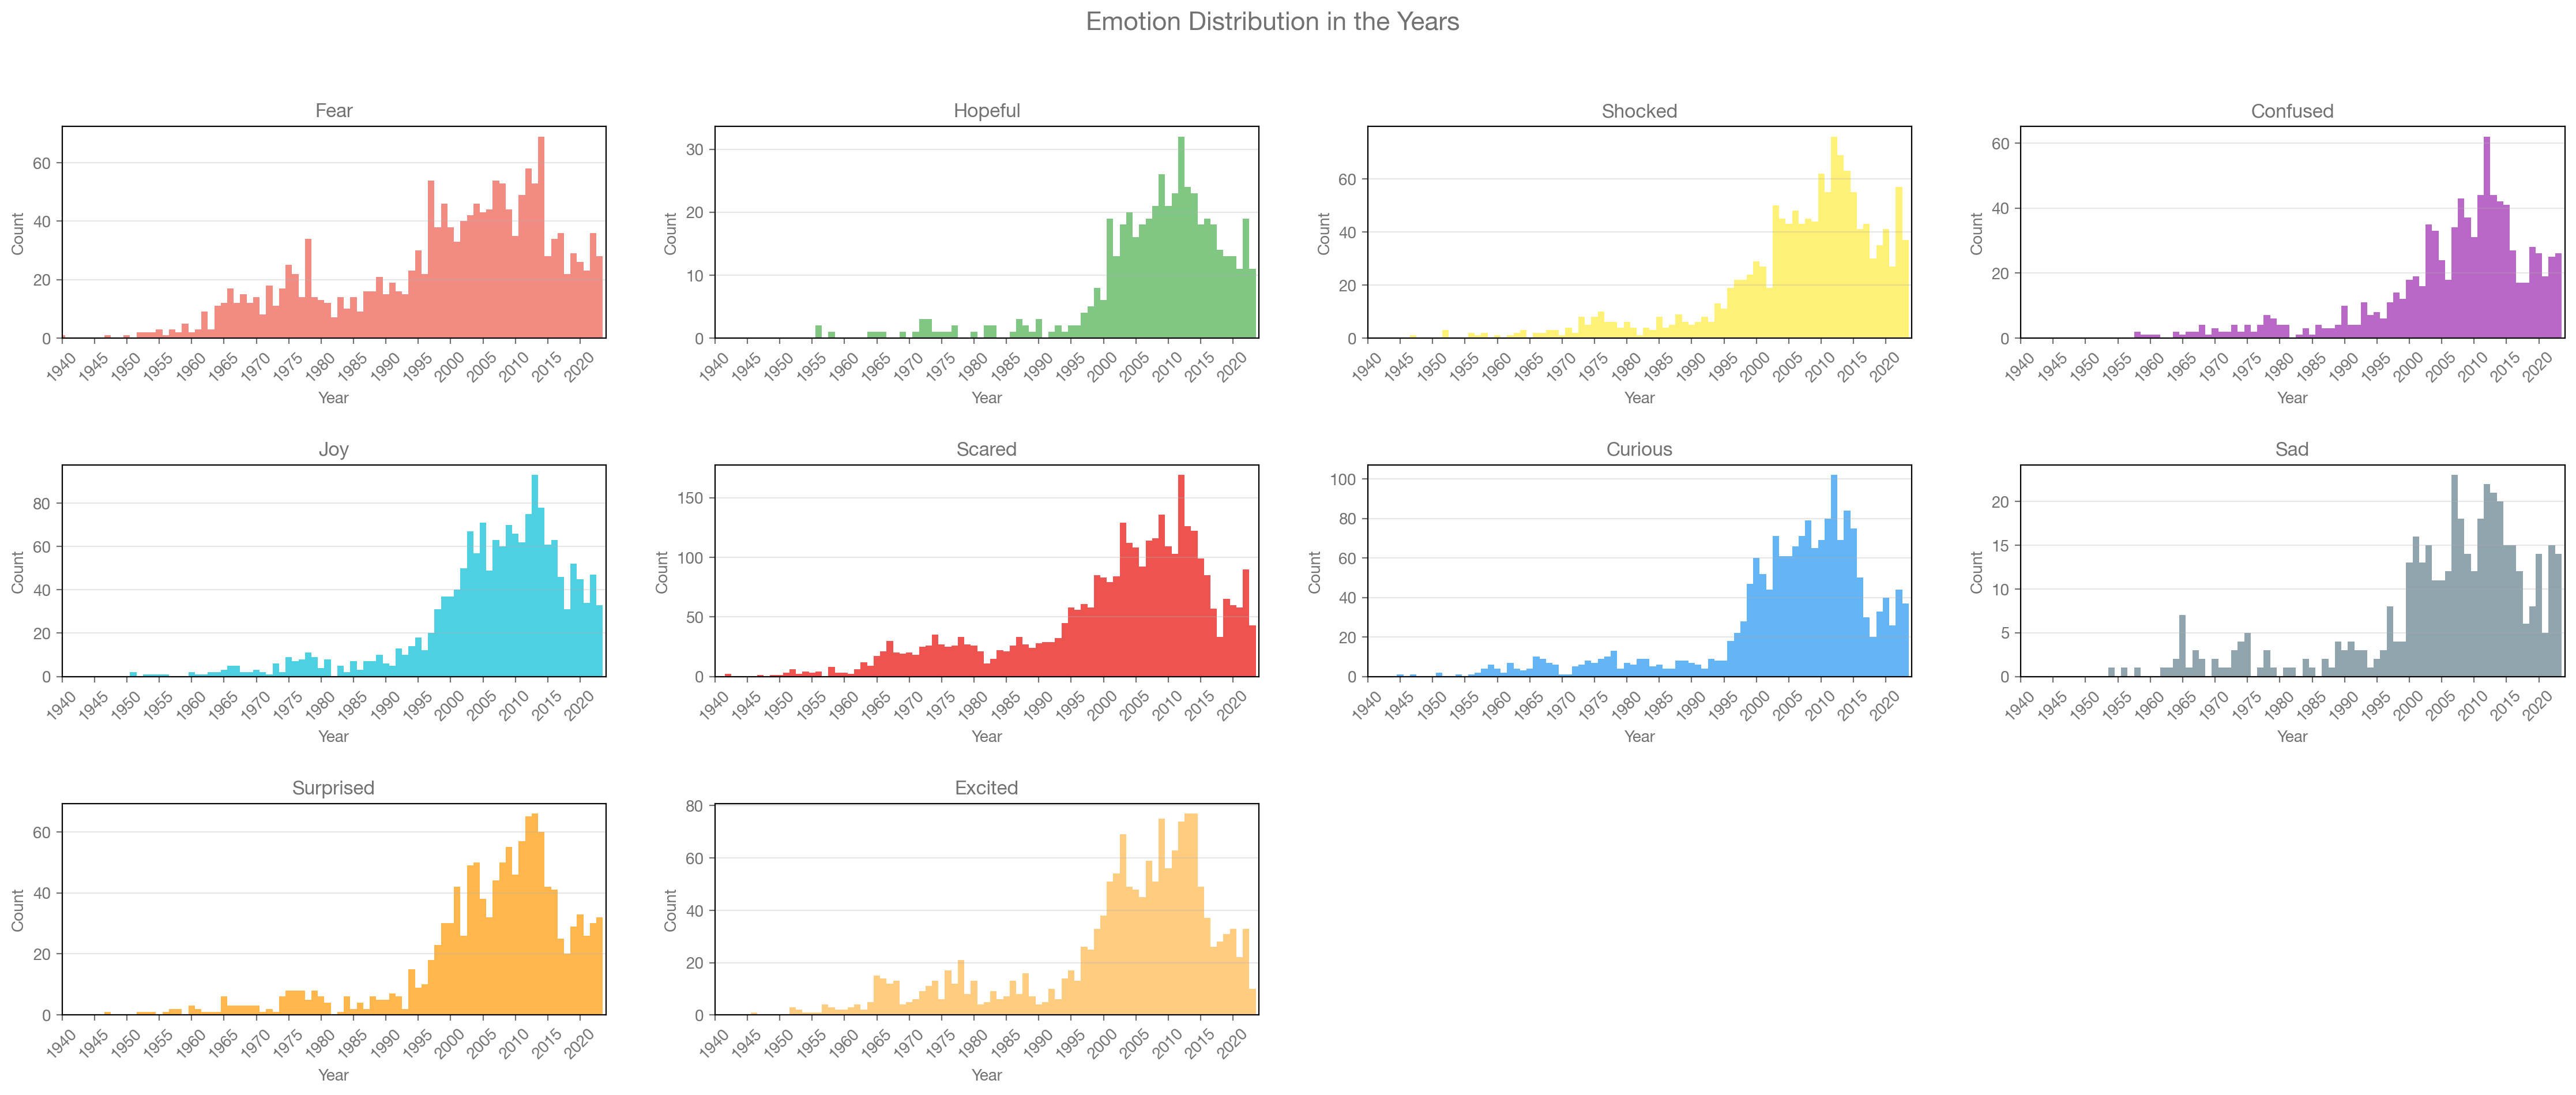

In [102]:
fig, axes = plt.subplots(3, 4, figsize=(28, 10))

# Define the year range
min_year = max(1940, int(df_sent['datetime'].dt.year.min()))
max_year = min(2024, int(df_sent['datetime'].dt.year.max()))

for e, ax in zip(emotion_keywords, axes.flatten()):
    # Filter the DataFrame for the current emotion
    df_emotion = df_sent[df_sent[e] == True]
    
    # Count occurrences by hour
    df_emotion_count = df_emotion['datetime'].dt.year.value_counts().sort_index().reset_index()
    df_emotion_count.columns = ['year', 'count']
    
    ax.bar(
        df_emotion_count['year'], 
        df_emotion_count['count'], 
        color=emotion_colors.get(e),
        width=1.0
    )
    ax.set_title(e.capitalize())
    ax.set_xlabel('Year')
    ax.set_xticks(range(min_year, max_year, 5))
    ax.set_xticklabels(range(min_year, max_year, 5), rotation=45)
    ax.set_xlim(min_year, max_year + 1)
    ax.set_ylabel('Count')
    ax.grid(axis='y', alpha=0.3)

# Hide unused subplots
for ax in axes.flatten()[len(emotion_keywords):]:
    ax.axis('off')

fig.suptitle('Emotion Distribution in the Years', fontsize=16)
plt.subplots_adjust(hspace=0.6, wspace=0.2)
plt.show()

All emotions show an increase after the year 2000, likely due to the rise of social media and the ease of reporting through the website, launched in 1995. However, they all peaked in 2012 before experiencing a decline. The causes for this phenomena were covered by [news](https://www.huffpost.com/entry/american-ufo-reports-down_b_2982532) but still remain unknown.

Fear and scare are the most frequent emotions during the period from 1940 to 2000. 

In [103]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, RangeTool, Legend
from bokeh.layouts import column
from bokeh.io import output_notebook, output_file

output_notebook()

# Prepare data for each emotion
emotion_data = {}
for emotion in emotion_keywords:
    df_emotion = df_sent[df_sent[emotion] == True]
    df_emotion_count = df_emotion['datetime'].dt.year.value_counts().sort_index().reset_index()
    df_emotion_count.columns = ['year', 'count']
    emotion_data[emotion] = ColumnDataSource(df_emotion_count)

# Create the main Bokeh figure
p = figure(
    title="Occurrences of Emotions per Year",
    height=300, width=650,
    x_axis_label='Year', y_axis_label='Count',
    x_range=(2000, 2023)
)

p.xaxis.ticker = list(range(1940, 2025, 1))  # one tick per year
p.xaxis.major_label_orientation = 0.785  # 45 degrees in radians

p.add_layout(Legend(), 'right')

# Create the range selection tool
select = figure(
    title="Drag the middle and edges of the selection box to change the range above.\nAlso use the legend to show or hide lines.",
    height=130, width=650, y_range=p.y_range,
    x_range=(min_year, max_year),
    tools="", toolbar_location=None,
)

renderers_p = []
renderers_select = []

# Add a line for each emotion to both plots, and keep references to renderers
for emotion in emotion_keywords:
    source = emotion_data[emotion]
    r1 = p.line(
        x='year', y='count', source=source, line_width=2,
        color=emotion_colors.get(emotion, 'blue'), alpha=0.8,
        legend_label=emotion.capitalize()
    )
    r2 = select.line(
        x='year', y='count', source=source, line_width=1,
        color=emotion_colors.get(emotion, 'blue'), alpha=0.5,
    )
    renderers_p.append(r1)
    renderers_select.append(r2)

# Set up legend
p.legend.click_policy = "hide"
p.grid.grid_line_alpha = 0.5
select.grid.grid_line_alpha = 0.3

# Add RangeTool
range_tool = RangeTool(x_range=p.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2
select.add_tools(range_tool)

# Synchronize visibility between main plot and select plot
# This uses a CustomJS callback to link the visibility of lines
for r1, r2 in zip(renderers_p, renderers_select):
    r1.js_link('visible', r2, 'visible')

# Export the visualization to an HTML file
output_file("../templates/emotion_patterns_with_legend.html")

show(column(p, select))

Loading BokehJS ...

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


As mentioned before, the first look at the chart highlights a spike in all emotions in 2022, followed by a quick drop afterwards.

Fear is clearly the most common emotion across the board, especially around 2012 and again in 2022. People mostly seem scared or unsettled by what they see. Curious is next, staying fairly steady, though sometimes Excited overtakes it.

Joy interestingly overtakes Fear in 2020, remaining above its line for all the rest of the time.

In general, while fear dominates, the mix of emotions tells us that these sightings can trigger a wide range of reactions — from awe to confusion to genuine excitement.

#### Prediction of scared in the years

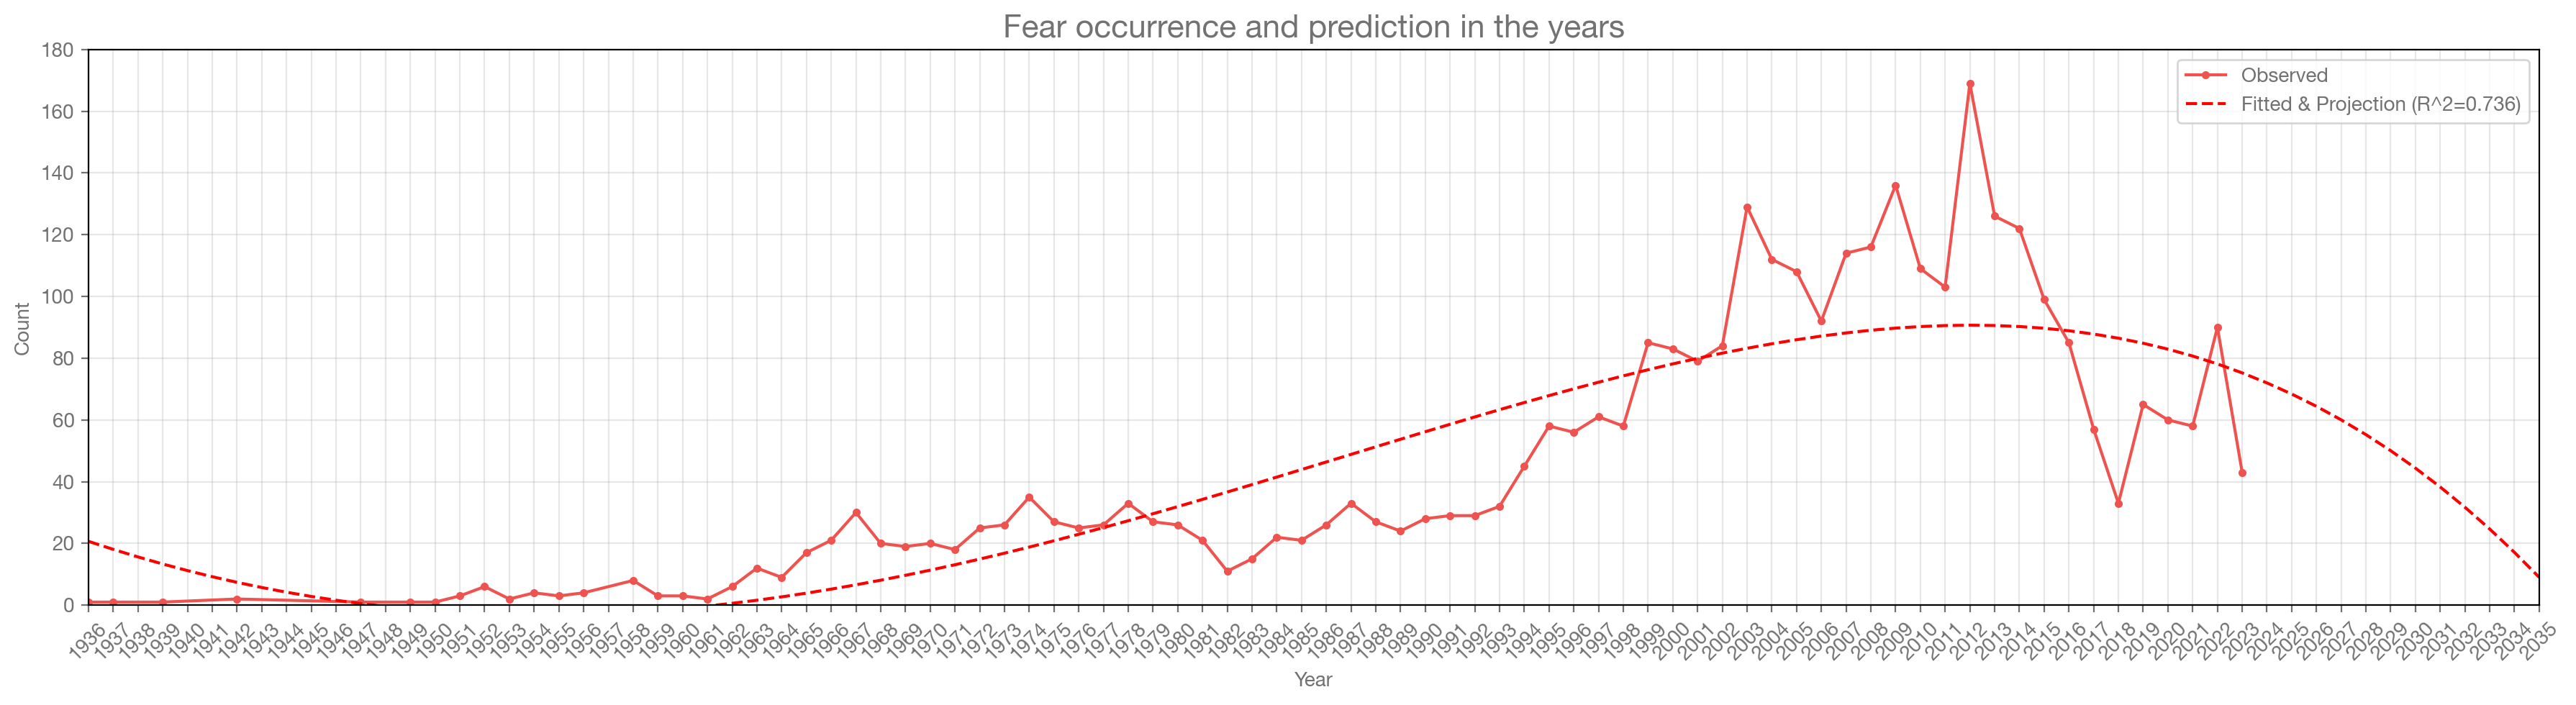

In [104]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Prepare data
df_emotion = df_sent[df_sent['scared'] == True]
df_emotion_count = df_emotion['datetime'].dt.year.value_counts().sort_index().reset_index()
df_emotion_count.columns = ['year', 'count']

min_year = int(df_emotion['datetime'].dt.year.min())
max_year = max(2036, int(df_emotion['datetime'].dt.year.max()))

# Fit a polynomial regression (degree=2 for a curve)
X = df_emotion_count['year'].values.reshape(-1, 1)
y = df_emotion_count['count'].values
poly = PolynomialFeatures(degree=20)
X_poly = poly.fit_transform(X)
model = LinearRegression().fit(X_poly, y)
r2 = model.score(X_poly, y)

# Predict for all years (observed + future)
all_years = np.arange(min_year, max_year).reshape(-1, 1)
all_X_poly = poly.transform(all_years)
all_counts = model.predict(all_X_poly)

# Plot observed, fitted, and projection
plt.figure(figsize=(18, 5))
plt.plot(df_emotion_count['year'], df_emotion_count['count'], marker='o', markersize=3, label='Observed', color=emotion_colors.get('scared'))
plt.plot(all_years.flatten(), all_counts, 'r--', label=f'Fitted & Projection (R^2={r2:.3f})')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Fear occurrence and prediction in the years', fontsize=16)
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(range(min_year, max_year), rotation=45)
plt.xlim(min_year, max_year - 1)
plt.ylim(0, max(max(df_emotion_count['count']), int(all_counts.max()) * 2))
plt.tight_layout()
plt.show()

Fitting a curve on the observed data, seems like that the frightening effect of sightings will be gone by 2035.

### Emotion vs Most occurring words

#### (ignore) By emotion
Apparently no relevant differences

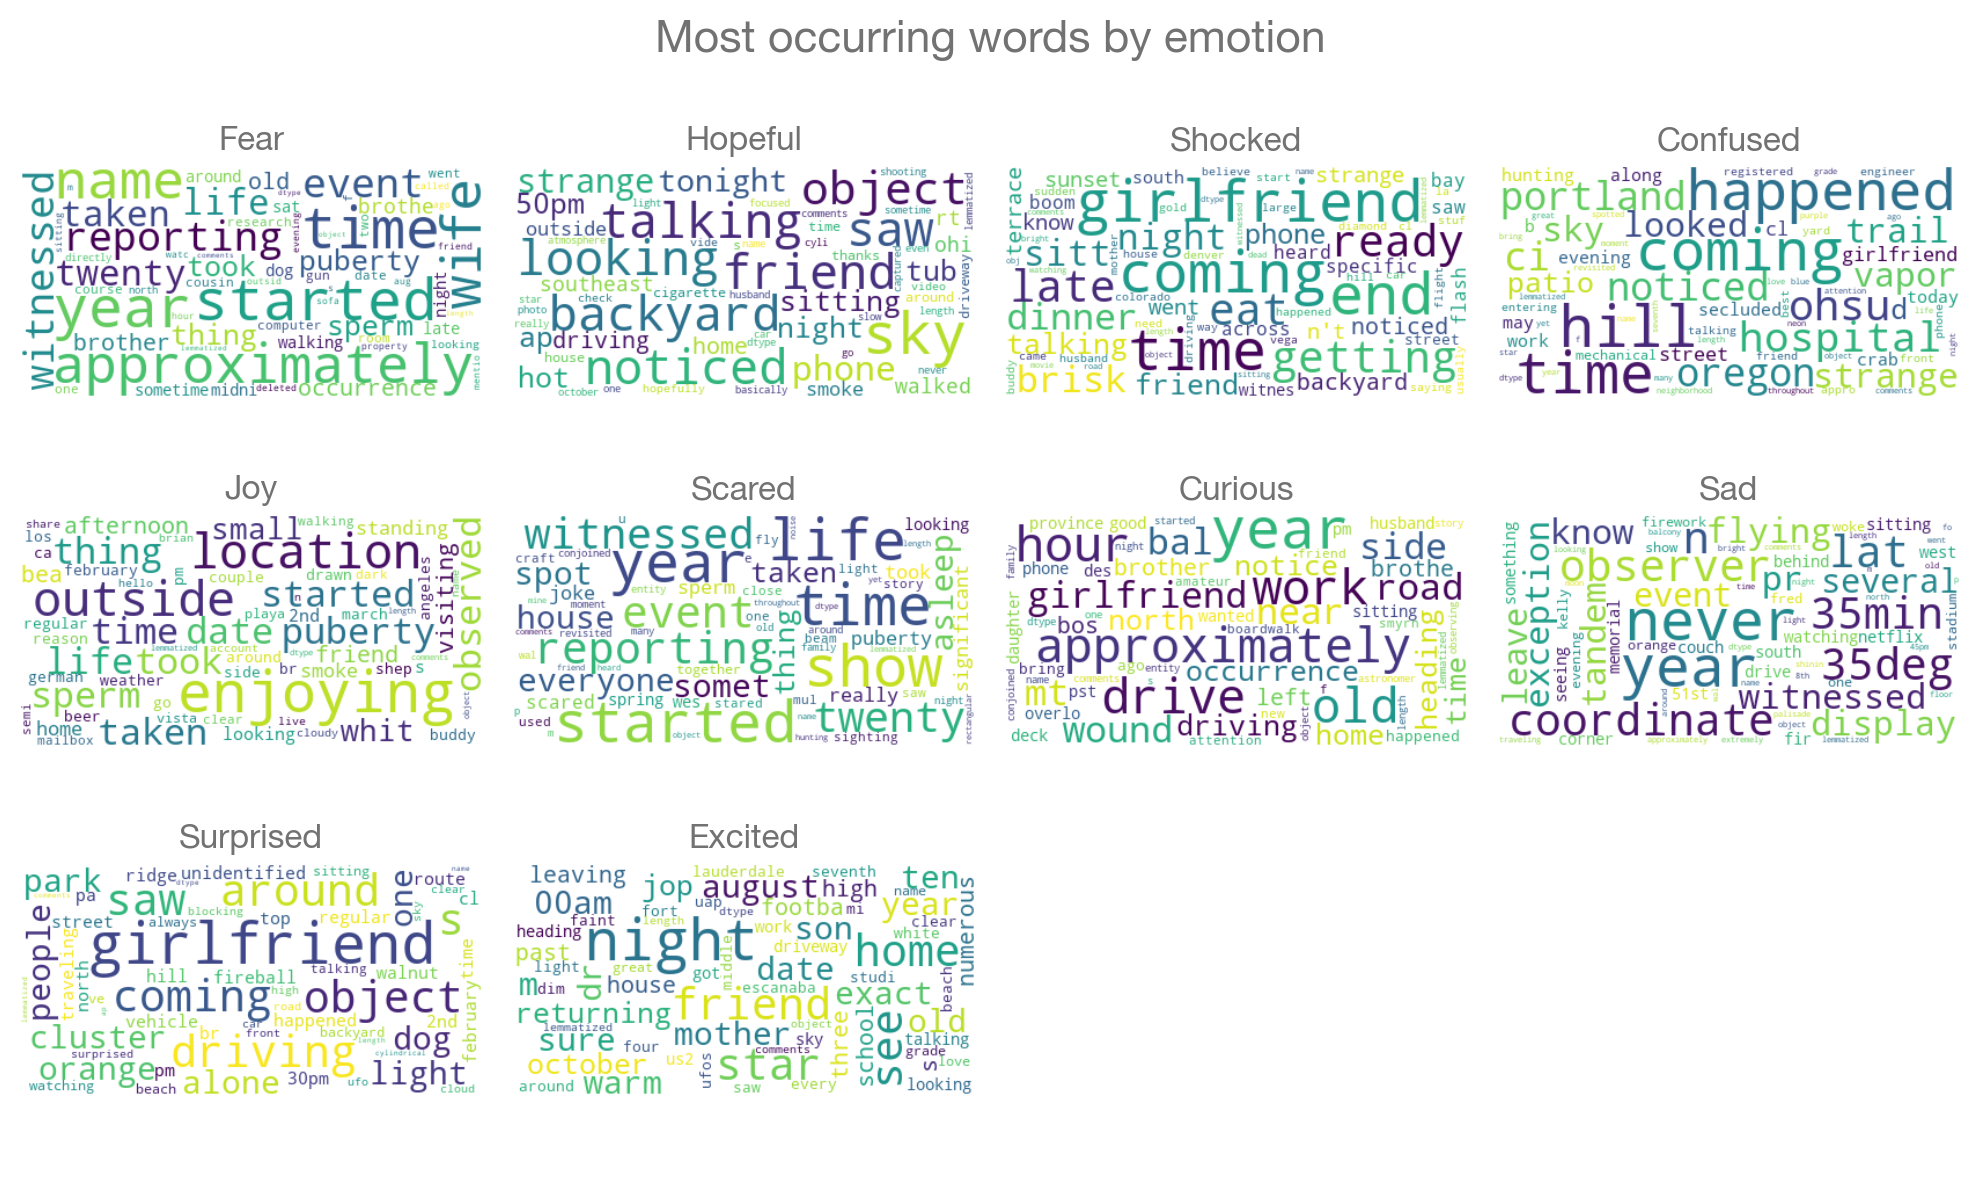

In [105]:
from wordcloud import WordCloud
 
fig, axes = plt.subplots(3, 4, figsize=(10, 6))

for ax, e in zip(axes.flatten(), emotion_keywords):
    subset = df_sent[df_sent[e] == True]
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(subset['lemmatized comments']).lower())
    ax.set_title(e.capitalize())
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")

# Hide unused subplots
for ax in axes.flatten()[len(emotion_keywords):]:
    ax.axis('off')

fig.suptitle('Most occurring words by emotion', fontsize=16)
plt.tight_layout()
plt.show()

#### Regardless of the emotion

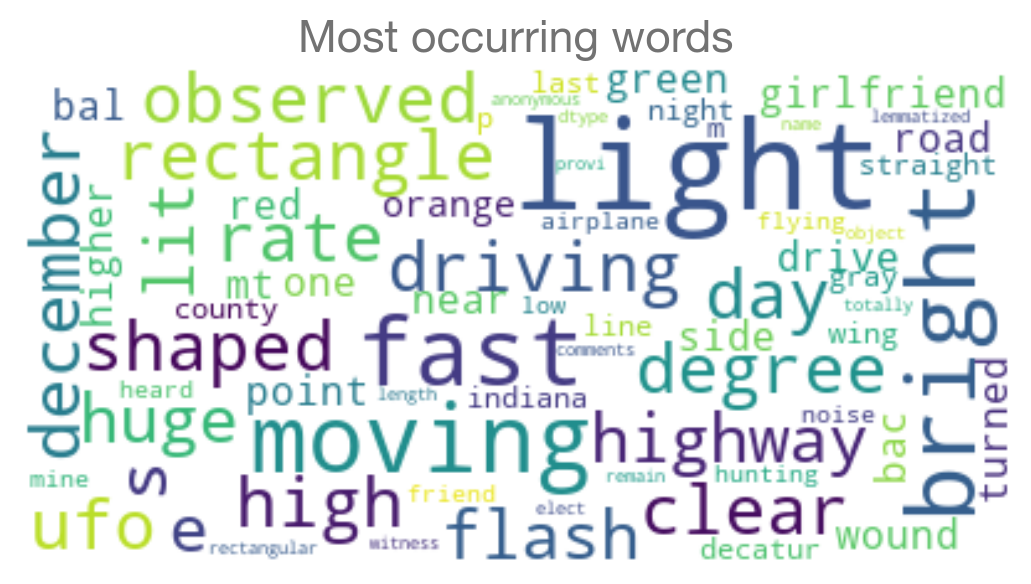

In [106]:
from wordcloud import WordCloud
 
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(df_sent['lemmatized comments']).lower())
plt.title('Most occurring words', fontsize=16)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### (ignore) Emotion vs Shape
Again not relevant based on emotion

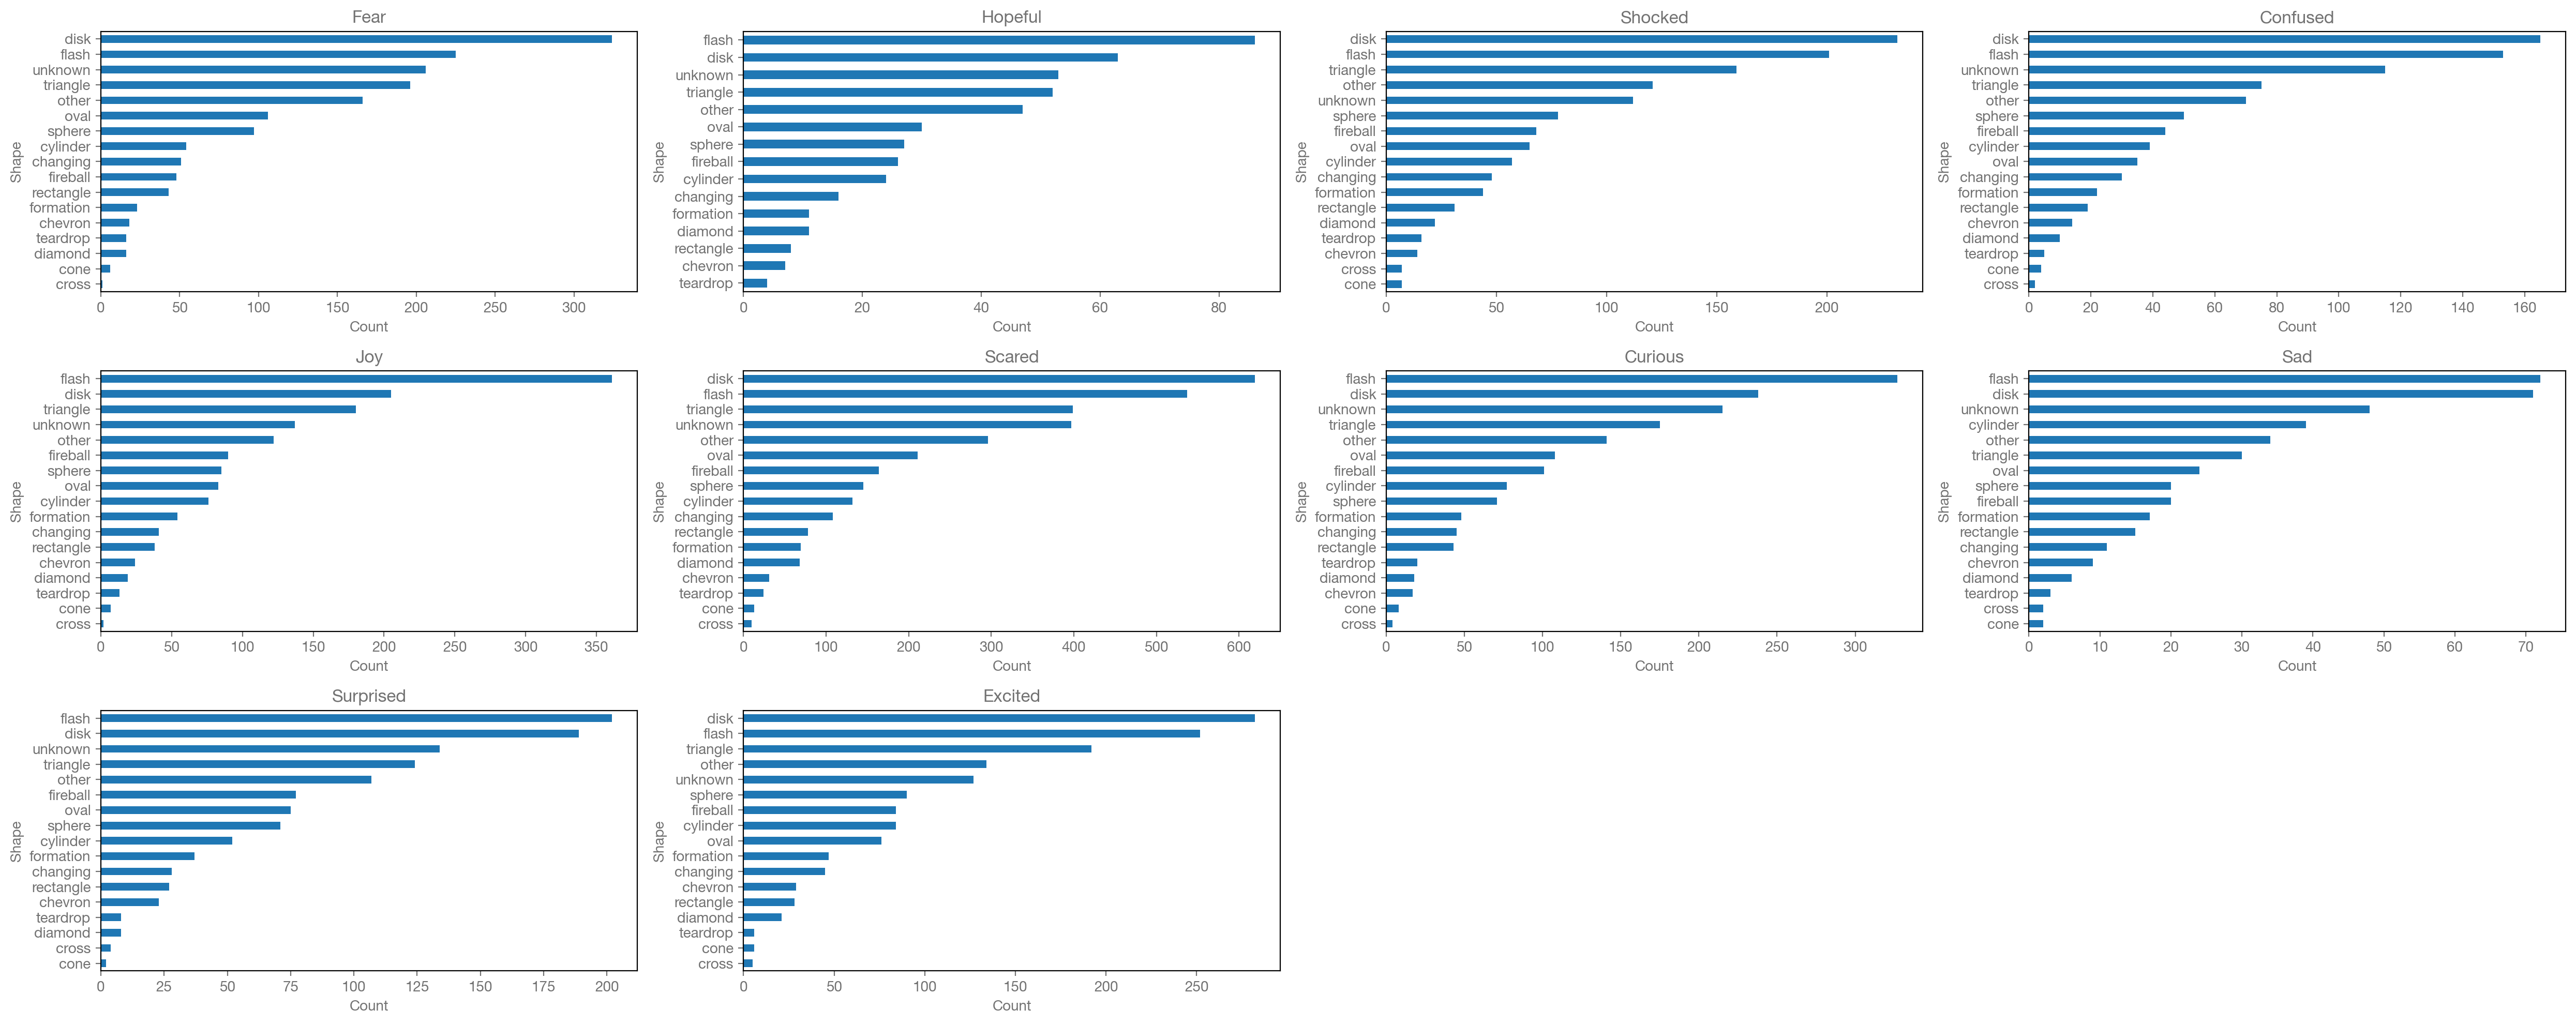

In [107]:
fig, axes = plt.subplots(3, 4, figsize=(25, 10))

for e, ax in zip(emotion_keywords, axes.flatten()):
    # Filter the DataFrame for the current emotion
    df_emotion = df_sent[df_sent[e] == True]
    df_emotion.groupby('shape')['shape'].count().sort_values(ascending=True).plot(kind='barh', ax=ax)
    ax.set_title(e.capitalize())
    ax.set_xlabel('Count')
    ax.set_ylabel('Shape')

# Hide unused subplots
for ax in axes.flatten()[len(emotion_keywords):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Emotion vs Duration

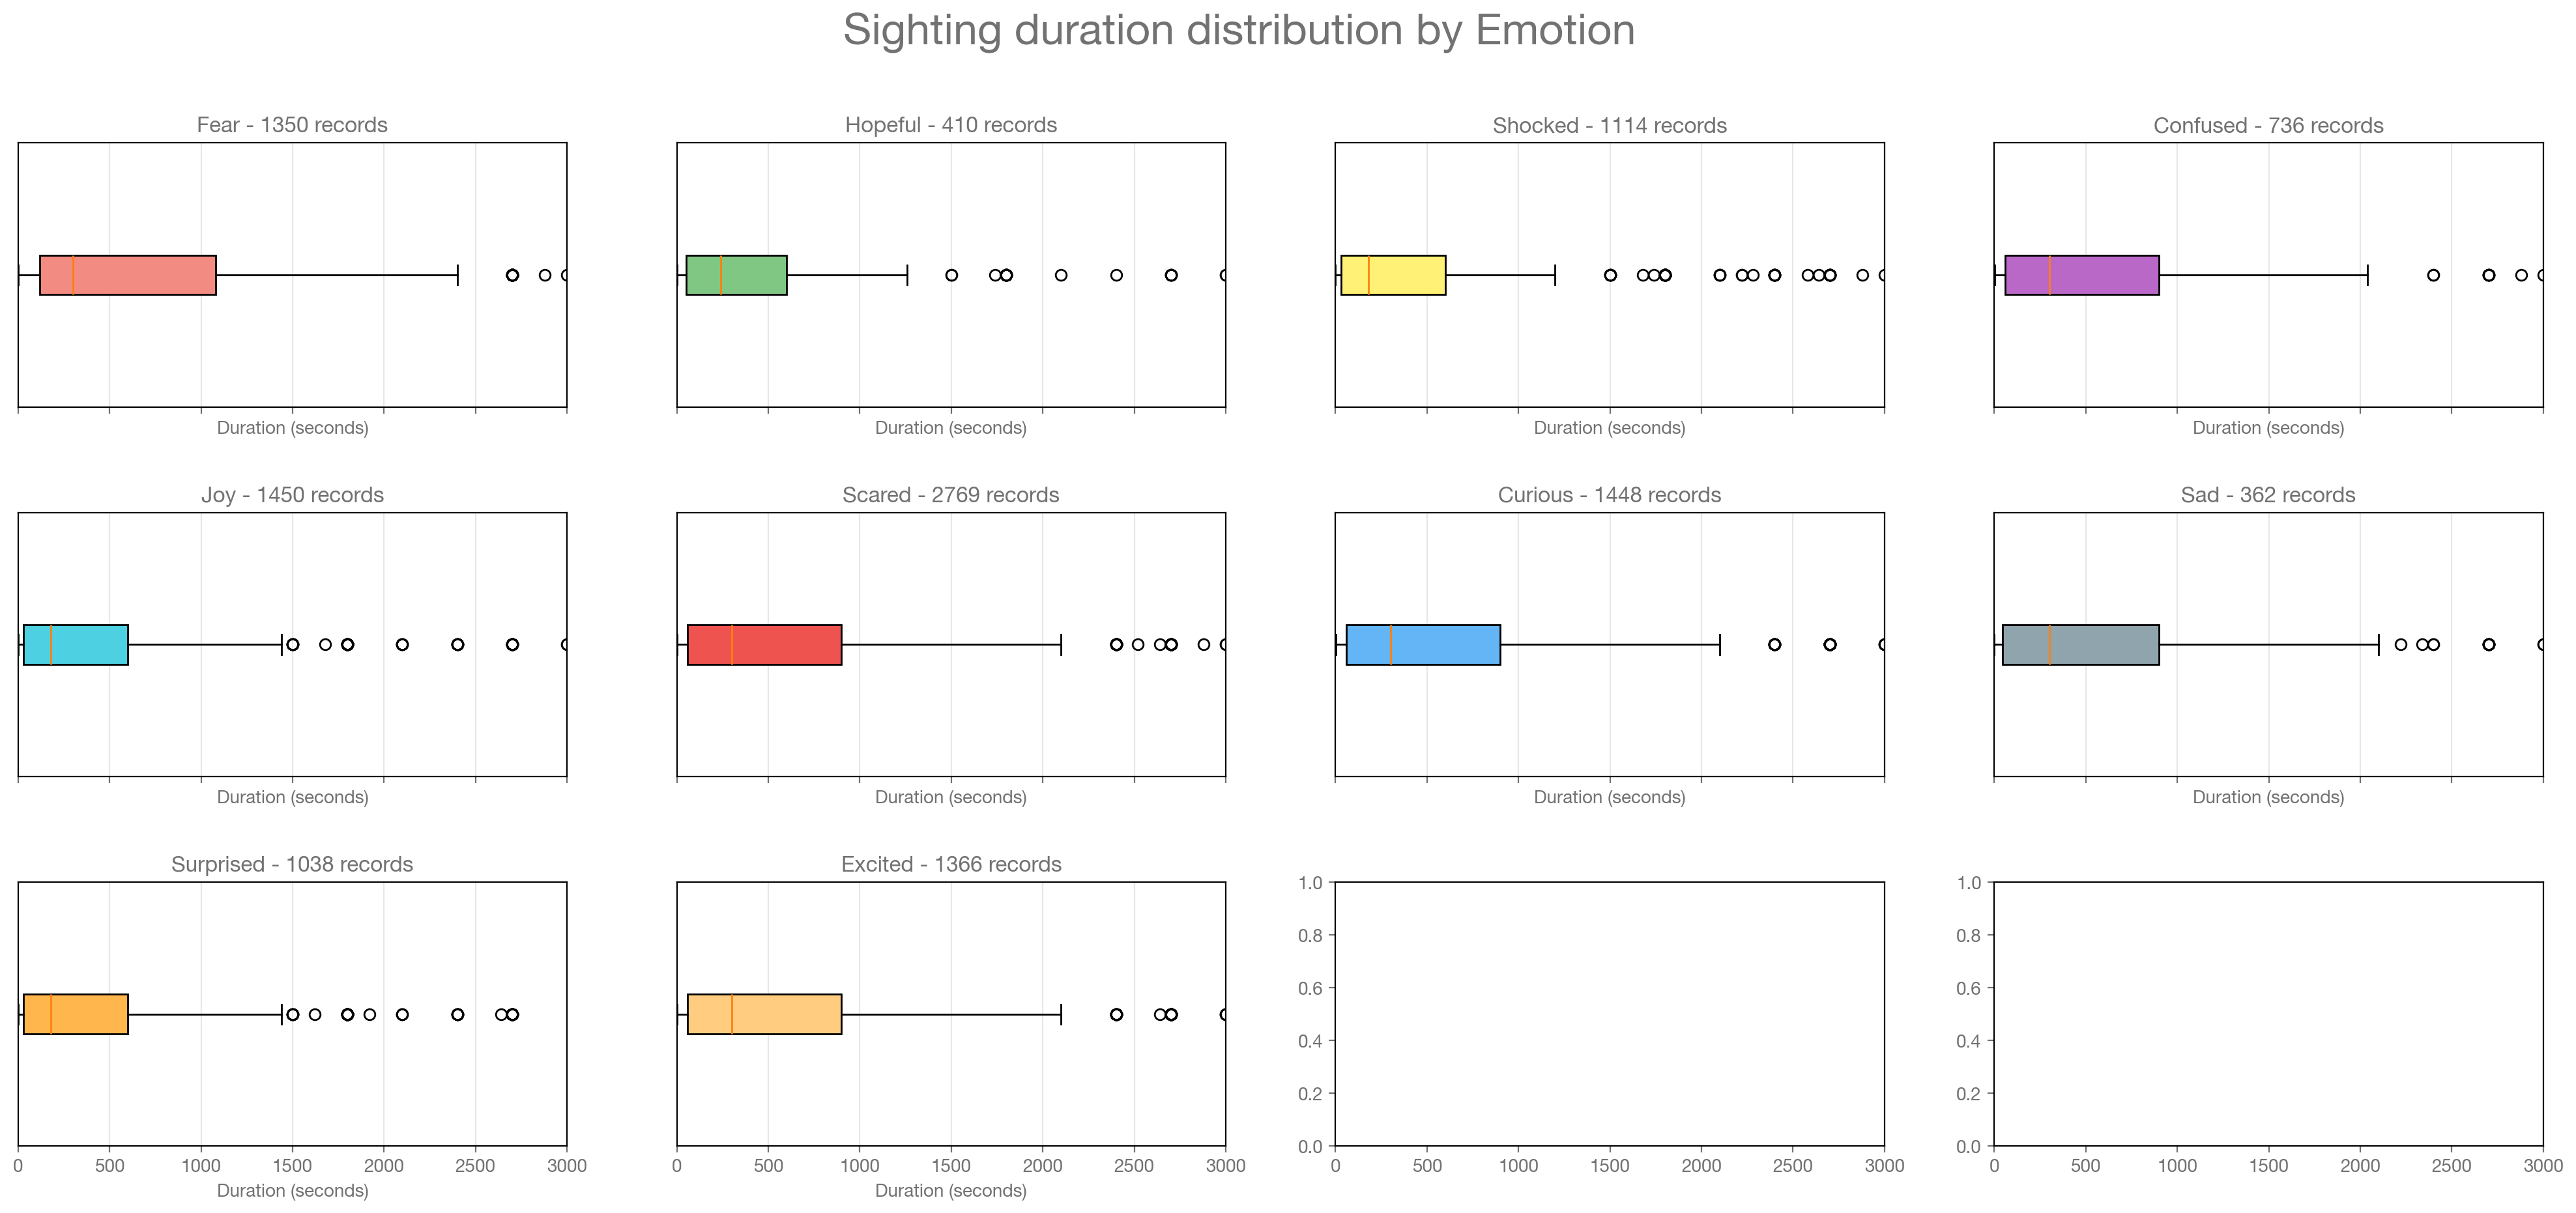

In [108]:
fig, axes = plt.subplots(3, 4, figsize=(25, 10), sharex=True)

for e, ax in zip(emotion_keywords, axes.flatten()):
    # Filter the DataFrame for the current emotion
    df_emotion = df_sent[df_sent[e] == True].copy().dropna(subset=['duration'])

    ax.boxplot(
        df_emotion['duration'], 
        vert=False, 
        patch_artist=True, 
        boxprops=dict(facecolor=emotion_colors.get(e))
    )
    ax.set_title(f'{e.capitalize()} - {len(df_emotion)} records')
    ax.set_xlabel('Duration (seconds)')
    ax.set_xlim(0, 3000)  # Set x-axis limit for better visibility
    ax.set_yticks([])  # Remove y-axis ticks for clarity
    ax.grid(axis='x', alpha=0.3)  # Add grid lines for x-axis

fig.suptitle('Sighting duration distribution by Emotion', fontsize=24)
plt.subplots_adjust(hspace=0.4, wspace=0.2)
plt.show()

The longest average durations come from Fear. You can see it clearly in the position of the box — the upper quartiles are visibly higher than most others. Hopeful and Shocked are among the shortest, with the box packed tightly near the start of the x-axis.

Whiskers also tell a story: Fear, Scared and some others have long whiskers, meaning their durations vary a lot. Hopeful and Shocked seem to follow the same trend as before, having much shorter whiskers: those emotions show up in more uniform, shorter sightings.

Shocked also stands out when it comes to the concentration of outliers in the analyzed range of duration. They show a bunch of scattered dots after the right whisker, even though their core durations are short — looks like rare, long events push those emotions over the edge.

### Cited movies

In [109]:
df_movies = df_sent.loc[
    df_sent['comments'].str.contains('movie', na=False),
    'comments'
]

print('There are ' + str(len(df_movies)) + ' records with the word "movie"')

# Mapping of movie names to publish years
movie_years = {
    "Twister": 1996,
    "Predator": 1987,
    "Armageddon": 1998,
    "Star Wars": 1977,
    "A scene out of a Spielberg movie": '?',
    "Old movie of the UFOs in Montana in the late forties": 1950,
    "Star Trek": 1979,
    "UFO Unplugged": 1997,
    "Deep impact": 1998,
    "Close Encounters of the Third Kind": 1977,
    "Independence Day": 1996,
    "E.T.": 1982,
    "The Day the Earth Stood Still": 1951,
    "War of the Worlds": 2005,
    "X-Files": 1998,
    "Interstellar": 2014,
}

# Prepare a list to collect results
movie_rows = []
for idx, row in tqdm(df_sent.iterrows(), total=len(df_sent)):
    comment = row['comments']
    year = row['datetime'].year if pd.notnull(row['datetime']) else None
    for movie, release_year in movie_years.items():
        if re.search(rf'\b{re.escape(movie)}\b', comment, re.IGNORECASE):
            label = f"{movie} ({release_year})"
            movie_rows.append({
                'Row ID': idx,
                'Movie': label,
                'Year': year,
                'Comment': comment
            })

# Create DataFrame
df_movies = pd.DataFrame(movie_rows)
df_movies.set_index('Row ID', inplace=True)
df_movies.sort_values(by='Movie', inplace=True)

print('There are ' + str(len(df_movies)) + ' records referencing movie titles')

df_movies

There are 1630 records with the word "movie"


  0%|          | 0/130963 [00:00<?, ?it/s]

There are 642 records referencing movie titles


Movie  Year  \
Row ID                                                    
51595        A scene out of a Spielberg movie (?)  1978   
36424                           Armageddon (1998)  2023   
99118                           Armageddon (1998)  1964   
42523                           Armageddon (1998)  1999   
114808  Close Encounters of the Third Kind (1977)  2018   
...                                           ...   ...   
72340                              X-Files (1998)  2022   
68740                              X-Files (1998)  2002   
60445                              X-Files (1998)  2012   
81486                              X-Files (1998)  2003   
63316                              X-Files (1998)  1996   

                                                  Comment  
Row ID                                                     
51595   My interest stems from my knowledge and experi...  
36424   2 lights were noticed together like Mars & a s...  
99118   This article will give you some information ab...  
42523   My parents, and my son and I were driving down...  
114808  I was watching the stars and noticed one of th...  
...                                                   ...  
72340   I was awaken approximately at 1 AM by a sound ...  
68740   at about 9:45pm i saw a light out in the dista...  
60445   It had a circular, aqua colored top that appea...  
81486   It was September 19,2003. I am 16 and male. I ...  
63316   Sorry this report is a few years late, but I h...  

[642 rows x 3 columns]

In [110]:
df_movies.groupby('Movie').size().sort_values(ascending=False).reset_index(name='Count')

Movie  Count
0                                    Star Trek (1979)    183
1                                    Star Wars (1977)    163
2                                     Predator (1987)     81
3                             Independence Day (1996)     67
4           Close Encounters of the Third Kind (1977)     37
5                                      X-Files (1998)     37
6                            War of the Worlds (2005)     24
7                                 Interstellar (2014)     17
8                                         E.T. (1982)     15
9                                      Twister (1996)      6
10                                 Deep impact (1998)      4
11                                  Armageddon (1998)      3
12               The Day the Earth Stood Still (1951)      2
13               A scene out of a Spielberg movie (?)      1
14  Old movie of the UFOs in Montana in the late f...      1
15                               UFO Unplugged (1997)      1

### Year distribution of 'Star Wars' movie

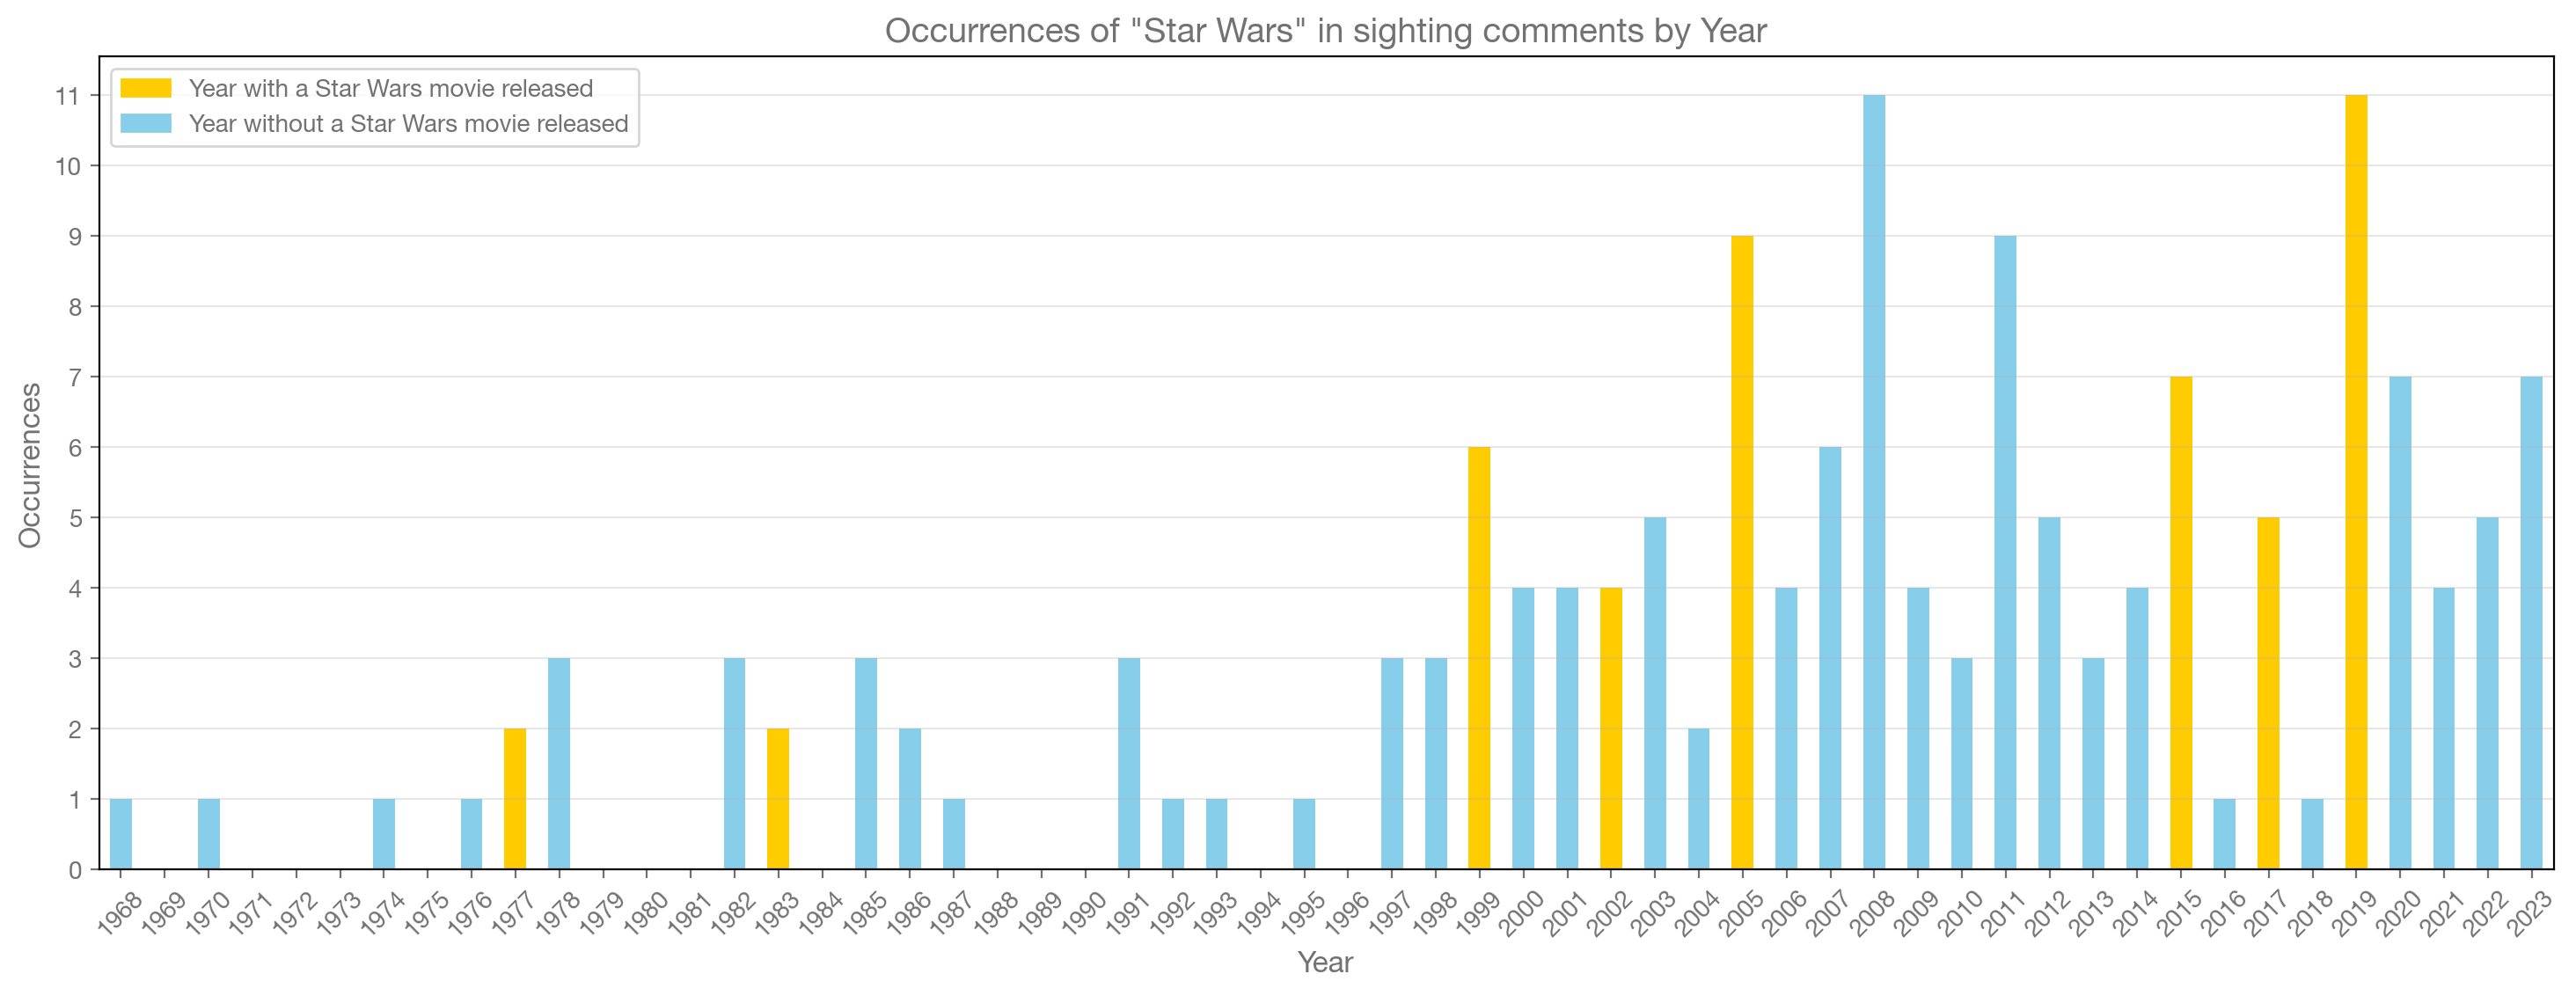

In [111]:
import matplotlib.patches as mpatches

df_star_wars = df_sent.loc[df_movies[df_movies['Movie'] == 'Star Wars (1977)'].index].copy()
star_wars_ref_by_year = (
    df_star_wars['datetime'].dt.year.value_counts()
    .reindex(np.arange(df_star_wars['datetime'].dt.year.min(), df_star_wars['datetime'].dt.year.max() + 1), fill_value=0)
    .sort_index()
)

# Define the years of Star Wars movie releases
star_wars_years = [1977, 1980, 1983, 1999, 2002, 2005, 2015, 2017, 2019]

# Assign colors to bars based on whether the year corresponds to a Star Wars movie release
colors = ['#ffcc00' if year in star_wars_years else 'skyblue' for year in star_wars_ref_by_year.index]

# Create a bar plot
plt.figure(figsize=(18, 6))
star_wars_ref_by_year.plot(kind='bar', color=colors)

release_patch = mpatches.Patch(color='#ffcc00', label='Year with a Star Wars movie released')
other_patch = mpatches.Patch(color='skyblue', label='Year without a Star Wars movie released')
plt.legend(handles=[release_patch, other_patch])

plt.title('Occurrences of "Star Wars" in sighting comments by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Occurrences', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.yticks(range(0, star_wars_ref_by_year.max() + 1))
plt.xticks(ticks=range(len(star_wars_ref_by_year.index)), labels=star_wars_ref_by_year.index, rotation=45)
plt.show()

From the plot, it is evident that, apart from the first two movies, sightings consistently peak around the release of new Star Wars movies. For instance, between 2014 and 2020, sightings rose and fell in sync with the release of three Star Wars films. While this could be coincidental, the references in the comments suggest that the movies may have influenced the reports.
It must be noted that the data shown reflects the stated date of the sighting, not the date in which it was posted. That's the reason why it is also referenced for sightings before the release of the first movie.